Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Радует, что ноутбук хорошо структурирован. Приятно проверять такие работы.
* Отлично, что тебе удалось освоить внутренний метод кодировки признаков для одной моделей.
* Над этим проектом нужно будет еще немного поработать. Однако, изменения не должны занять много времени.
* В работе я оставил несколько советов. Буду рад, если ты учтешь их.
* С радостью отвечу на твои вопросы, если они есть. Лучше всего их собрать в следующей ячейке. Жду новую версию проекта.

### <font color='orange'>Общее впечатление (ревью 2)</font>
* Для удобства все новые комментарии обозначены фразой "ревью 2".
* Удачи в доработке!

### <font color='orange'>Общее впечатление (ревью 3)</font>
* После исправлений проект улучшился и теперь он может быть зачтен.
* Таблица в выводе ОК, но в тексте лучше собрать информацию со всех шагов.
* Удачи в дальнейшем обучении и следующих работах!

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Осуществим подготовку к подготовке: загрузим необходимые модели.

In [1]:
import pandas as pd
import numpy as np
import os
import time

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error as mse

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

Загрузим исходные данные с полными путями.

In [2]:
df = pd.read_csv(os.path.join('https://code.s3.yandex.net/datasets/autos.csv'),
                   parse_dates=['DateCrawled', 'LastSeen', 'DateCreated'])
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46


Посмотрим на информацию о датасете:

In [3]:
df.shape

(354369, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null datetime64[ns]
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null datetime64[ns]
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 43.3+ MB


И на число пропусков:

In [5]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Выведем основные показатели.

In [6]:
print("Число марок автомобилей:", len(df["Brand"].unique()))
print("Число моделей автомобилей:", len(df["Model"].unique()))
print("Кузов автомобиля:", len(df["VehicleType"].unique()))
print("Средний пробег: {:.0f}".format(df["Kilometer"].mean()))

Число марок автомобилей: 40
Число моделей автомобилей: 251
Кузов автомобиля: 9
Средний пробег: 128211


<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен.
</div>

Удалим колонки, не имеющие к нам отношения.

In [7]:
col_drop = ['DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures']
df = df.drop(columns=col_drop)

cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType',
           'Brand', 'RegistrationMonth', 'NotRepaired']

<div class="alert alert-block alert-success">
<b>Успех:</b> Согласен, что даты и константный признак нам не нужны.
</div>

Создадим функцию show_na, которая выводит данные о пробелах и применим её:

In [8]:
def show_na(df):
    data_info = (df.isna() | df.isnull()).sum()
    res = (pd.concat([data_info / df.shape[0], data_info], axis=1,  keys=['percent', 'abs'])
           .sort_values('percent', ascending=False))
    return res

show_na(df)

,percent,abs
NotRepaired,0.200791,71154
VehicleType,0.105794,37490
FuelType,0.092827,32895
Gearbox,0.055967,19833
Model,0.055606,19705
Price,0.000000,0
RegistrationYear,0.000000,0
Power,0.000000,0
Kilometer,0.000000,0
RegistrationMonth,0.000000,0


Заполним пропуски:

In [9]:
df[cat_columns] = df[cat_columns].fillna('Nan')
df.isna().sum().sum()

0

<div class="alert alert-block alert-success">
<b>Успех:</b> Заполнить пропуски таким образом – хорошее и достаточно безопасное решение.
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> В данных етсь аномалии. Пожалуйста, удали их.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Перенёс комментарий повыше - до гистограмм. По поводу аномалий. Можно попробовать решить вопрос с годом (выбросы явно выходят за рамки логики) и что-то решить с price и power. Приступим:
</div>

In [10]:
def year(value):
    if value > 2020:
        return 2020
    elif value < 1930:
        return 1930
    else:
        return value
df["RegistrationYear"] = df["RegistrationYear"].apply(year)
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1
df.loc[df['Power'] > 3500, 'Power'] = 3500

In [11]:
def pricepower(frame,column):
    q25=np.array(frame[column].quantile(0.25))
    
    q75=np.array(frame[column].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(frame[column].index,frame[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество строк, выбранных для удаления ' + str(column)+":",len(del_index))
    return del_index

In [12]:
array_num_col = ["Price","Power"]
count = 0 
for column in array_num_col:
    index_del = pricepower(df,column)
    count += len(index_del)
    df = df.drop(index_del,axis = 0)
print("Было удалено:", count)

Количество строк, выбранных для удаления Price: 18979
Количество строк, выбранных для удаления Power: 5153
Было удалено: 24132


А теперь снова: Построим гистограммы по основным параметрам:

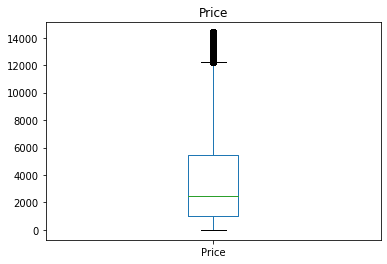

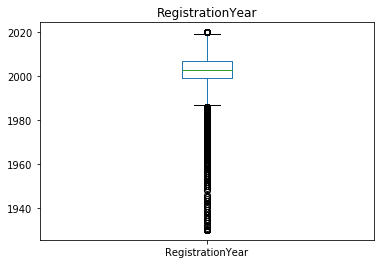

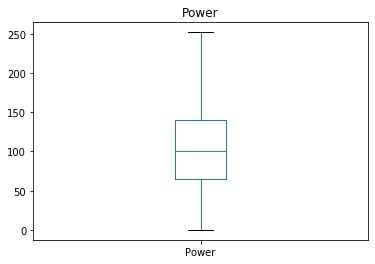

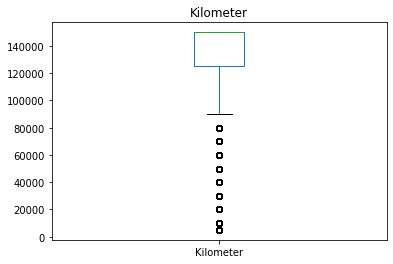

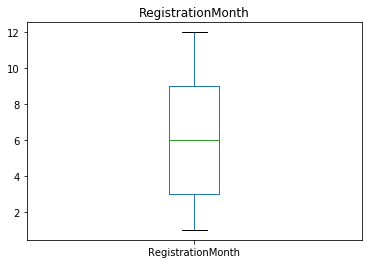

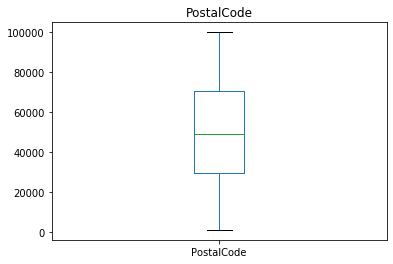

In [13]:
numerical = df.select_dtypes(include='number')

for col in numerical:
    df[col].plot.box()
    plt.title(col)
    plt.show()

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Спасибо!
</div>

## Обучение моделей

Мы напишем функцию model_eval, на вход которой будут подаваться модель и датасеты, а она будет возвращать время обучения, время предсказания и rmse.

In [14]:
def model_eval(model, X_train, y_train, X_test, y_test):
    
    start = time.time()    
    model.fit(X_train, y_train)
    training_time = time.time() - start
    
    start = time.time()  
    y_pred = model.predict(X_test)
    predict_time = time.time() - start

    return training_time, predict_time, mse(y_test, y_pred)**0.5

И разобьём данные на train и test, в соотношении 4 к 1, а сам train на train_valid и valid, так же в соотношении 4 к 1.

In [15]:
X = df.drop(columns='Price')
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
X_train_valid, X_valid, y_train_valid, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=21)

<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано правильно.
</div>

## Ridge

Подготовим пайплайн OHE -> scaler -> ridge, найдём лучшие параметры модели на кросс-валидации, измерим время.

In [16]:
res = []

In [17]:
pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', Ridge(random_state=21))
])

params = [
    {
        'model__alpha': np.logspace(-2, 2, 20)
    } 
]

In [18]:
cv = KFold(n_splits=3, shuffle=True, random_state=21)

grid = GridSearchCV(pipe,
                    param_grid=params,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=False)

In [19]:
%%time
grid.fit(X_train_valid, y_train_valid);

CPU times: user 4min 55s, sys: 2.72 s, total: 4min 58s
Wall time: 5min 3s


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ohe',
                                        OneHotEncoder(categorical_features=None,
                                                      categories=None,
                                                      drop=None,
                                                      dtype=<class 'numpy.float64'>,
                                                      handle_unknown='ignore',
                                                      n_values=None,
                                                      sparse=True)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=False,
                                                       with_std=Tru...
       6.95192796e

Зафиксируем результат, применим best_params_

In [20]:
grid.best_params_

{'model__alpha': 100.0}

Добавим в массив для последующего наглядного сравнения.

In [21]:
res.append(model_eval(grid.best_estimator_, X_train_valid, y_train_valid, X_valid, y_valid))

## LightGBM 

Что касается LightGBM, подготовим категориальные признаки через Label Encoder, найдём лучшие параметры (Scikit-learn), замерим время, обучив модель по всей train-выборке.

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Закомментируем.
</div>

encoder = LabelEncoder()

lgb_train = X_train_valid.copy()
lgb_test = X_valid.copy()
lgb_full_train = X_train.copy()
lgb_full_test = X_test.copy()


cat_col_num = []

for col in cat_columns:
    lgb_train[col] = encoder.fit_transform(lgb_train[col])
    lgb_test[col] = encoder.transform(lgb_test[col])
    lgb_full_train[col] = encoder.fit_transform(lgb_full_train[col])
    lgb_full_test[col] = encoder.transform(lgb_full_test[col])
    cat_col_num.append(df.columns.to_list().index(col))

gbm = lgb.LGBMRegressor(boosting_type='gbdt', verbose=0, seed=21)


params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'n_estimators': [40, 60],
    'num_leaves': [21, 31, 41],
}

grid_gbm = GridSearchCV(gbm,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=True)

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> LabelEncoder предназначен для кодировки целевой колонки, так указано в <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html">документации</a>. Для кодировки признаков лучше использовать OrdinalEncoder.
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> У модели lightGBM также существует внутренний метод кодировки. Для этого достаточно изменить тип колонок с категориальными признаками на соответствующий: .astype('category').
</div>

In [22]:
encoder = OrdinalEncoder()

lgb_train = X_train_valid.copy()
lgb_test = X_valid.copy()
lgb_full_train = X_train.copy()
lgb_full_test = X_test.copy()

cat_col_num = []

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Вот здесь затык, и пока что никто в чатах не смог помочь. Пытался и так и эдак, ориентировался сюда https://coderoad.ru/56502864/%D0%98%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5-OrdinalEncoder-%D0%B4%D0%BB%D1%8F-%D0%BF%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D1%85-%D0%B7%D0%BD%D0%B0%D1%87%D0%B5%D0%BD%D0%B8%D0%B9-%D0%B2 
    Явно что-то не понимаю.
    Тут тоже читал: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html
    Вернул пока ниже старый код, чтобы не позориться. Подскажи, пожалуйста.
</div>

In [27]:
for col in cat_columns:
    lgb_train[[col]] = encoder.fit_transform(lgb_train[[col]])
    lgb_test[[col]] = encoder.fit_transform(lgb_test[[col]])
    lgb_full_train[[col]] = encoder.fit_transform(lgb_full_train[[col]])
    lgb_full_test[[col]] = encoder.fit_transform(lgb_full_test[[col]])
    cat_col_num.append(df.columns.to_list().index(col))

<div class="alert alert-block alert-danger">

<b>Ошибка (ревью 2):</b> OrdinalEncoder применяется к датафрейму (двумерному массиву), а LaberEncoder к одной колонке (одномерному массиву). Корректнее всего применить OrdinalEncoder ко всему датасету и передать в параметр cat_features категориальные колонки, но можешь просто заменить `lgb_train[col]` на `lgb_train[[col]]`.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Ок.
</div>

In [28]:
gbm = lgb.LGBMRegressor(boosting_type='gbdt', verbose=0, seed=21)


params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'n_estimators': [40, 60],
    'num_leaves': [21, 31, 41],
}

grid_gbm = GridSearchCV(gbm,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=True)

In [29]:
%%time
grid_gbm.fit(lgb_train, y_train_valid);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  6.0min finished


CPU times: user 5min 57s, sys: 1.4 s, total: 5min 58s
Wall time: 6min 3s


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=No...
                                     reg_alpha=0.0, reg_lambda=0.0, seed=21,
                                     silent=True, subsample=1.0,
                                     subsample_for_bin=200000, subsample_freq=0,
                                     verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': array([0.001     , 0.00562341,

Далее, делаем всё то же самое, что и выше:

In [30]:
grid_gbm.best_params_

{'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 41}

In [31]:
res.append(model_eval(grid_gbm.best_estimator_, lgb_train, y_train_valid, lgb_test, y_valid))

## CatBoost

Всё аналогично.

In [32]:
cbr = CatBoostRegressor(random_seed=21,
                        loss_function='RMSE',
                        silent=True,
                        cat_features=cat_columns)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [40, 60],
    'depth': [6, 8, 10],
}

grid_cbr = GridSearchCV(cbr,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=False)

In [33]:
%%time
grid_cbr.fit(X_train_valid, y_train_valid);

CPU times: user 16min 15s, sys: 1min 39s, total: 17min 55s
Wall time: 19min 40s


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7fa353827e50>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [6, 8, 10], 'iterations': [40, 60],
                         'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=False)

In [34]:
grid_cbr.best_params_

{'depth': 10, 'iterations': 60, 'learning_rate': 0.1778279410038923}

In [35]:
res.append(model_eval(grid_cbr.best_estimator_, X_train_valid, y_train_valid, X_valid, y_valid))

<div class="alert alert-block alert-success">
<b>Успех:</b> Радует, что ты попробовал несколько разных моделей!
</div>

# Анализ моделей

Нам необходимо соединить данные в один датафрейм и посмотреть результаты на валидационной выборке.

In [36]:
pd.DataFrame(data=res,
             index=['Ridge', 'LightGBM', 'CatBoost'],
             columns=['training_time', 'predict_time', 'score'])

,training_time,predict_time,score
Ridge,7.635958,0.117303,1736.652808
LightGBM,5.684302,0.302475,1515.206004
CatBoost,23.105069,0.161013,1483.870332


<div class="alert alert-block alert-success">
<b>Успех:</b> Собрать все показатели в одной таблице – хорошая идея!
</div>

<b>В данном случае, наиболее подходящей моделью с оптимальным качеством и быстродействием оказался LightGBM</b>. 

Результат: Заказчик должен посмотреть на предъявленную таблицу и остаться доволен! Теперь у него не будет проблем в определении стоимости.

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было сделать финальный вывод подробнее.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> В принципе, я всегда пишу вывод, но в этом случае, мне показалось, очень удачный вариант с таблицей.
</div>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей